In [1]:
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
number_sample = mnist.train.num_examples
input_dim =784 #28*2
w = h =28

In [5]:
class VariationalAutoEncoder(object):
    def __init__(self,learning_rate=1e-4,batch_size=100,n_z=5):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        
        #build a network
        self.build()
        #launch a session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    #build a network
    def build(self):
        #input
        self.x = tf.placeholder(name='x',dtype=tf.float32,shape=[None,input_dim])  #shape=(batch_size,input_dim)

        #encoder
        #slim.fc(input,output_dim,scope,act_fn)
        f1 = fc(self.x,512,scope='enc_fc1',activation_fn=tf.nn.elu)  #scope is the name of the operation
        f2 = fc(f1,384,scope='enc_fc2',activation_fn=tf.nn.elu)  
        f3 = fc(f2,256,scope='enc_fc3',activation_fn=tf.nn.elu)  
        
        self.z_mu = fc(f3,self.n_z,scope='enc_fc4_mu',activation_fn=None)
        #log(sigma^2)
        self.log_sigma_z_sq = fc(f3,self.n_z,scope='enc_fc4_sigma',activation_fn=None)

        #N(z_mu,z_sigma)
        eps = tf.random_normal(shape=tf.shape(self.log_sigma_z_sq),mean=0,stddev=1,dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.log_sigma_z_sq)) * eps

        #decoder
        
        g1 = fc(self.z,256,scope='dec_f1',activation_fn=tf.nn.elu)
        g2 = fc(g1,384,scope='dec_f2',activation_fn=tf.nn.elu)
        g3 = fc(g2,512,scope='dec_f3',activation_fn=tf.nn.elu)
        
        self.x_hat = fc(g3,input_dim,scope='dec_f4',activation_fn=tf.sigmoid)
        
        #loss
        #reconstruction loss
        # x<->x_hat
        #H(x,x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(self.x*tf.log(self.x_hat+epsilon)+(1-self.x)*tf.log(1-self.x_hat+epsilon),axis=1)
        
        #latent loss
        #KL divergence: measure the difference between two distributions
        #the latent distribution and N(0,1)
        latent_loss = -0.5*tf.reduce_sum(1+self.log_sigma_z_sq-tf.square(self.z_mu)- tf.exp(self.log_sigma_z_sq),axis=1)
        
        #total loss
        self.loss = tf.reduce_mean(recon_loss+latent_loss)
        
        #optimiser
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        
    #execute single forward and backward pass    
    #report loss
    def run_single_step(self,x):
        _, loss = self.sess.run([self.train_op,self.loss], feed_dict={self.x: x})
        return loss
        
    #reconstruction
    #x->x_hat
    def reconstruction(self,x):
        return self.sess.run(self.x_hat , feed_dict={self.x: x})
        
    #generation
    #z->x_hat
    def generate(self,z):
        return self.sess.run(self.x_hat,feed_dict={self.z: z})

    #transformation of features
    #x->z
    def transformer(self,x):
        return self.sess.run(self.z,feed_dict={self.x: x})

In [6]:
def trainer(learning_rate=1e-4,batch_size=100,epoch=100,n_z=10):
    #model
    model = VariationalAutoEncoder(learning_rate=learning_rate,batch_size=batch_size,n_z=n_z)
    
    #training loop
    for ep in range(epoch):
        for iter in range(number_sample // batch_size):
            #obtain a mini-batch
            #tuple:images,labels
            batch = mnist.train.next_batch(batch_size)
            
            #train: execute forward and backward pass
            loss = model.run_single_step(batch[0])
        print('[Epoch {}] Loss: {}'.format(ep,loss))
    print('Done!')
    return model

In [7]:
tf.reset_default_graph()
model = trainer(learning_rate=1e-4,batch_size=100,n_z=5) 

[Epoch 0] Loss: 169.6300811767578
[Epoch 1] Loss: 158.41561889648438
[Epoch 2] Loss: 143.91836547851562
[Epoch 3] Loss: 137.3026580810547
[Epoch 4] Loss: 129.2591552734375
[Epoch 5] Loss: 133.57595825195312
[Epoch 6] Loss: 129.3802947998047
[Epoch 7] Loss: 127.92584991455078
[Epoch 8] Loss: 127.67394256591797
[Epoch 9] Loss: 127.39030456542969
[Epoch 10] Loss: 126.32938385009766
[Epoch 11] Loss: 135.27346801757812
[Epoch 12] Loss: 126.88207244873047
[Epoch 13] Loss: 120.04894256591797
[Epoch 14] Loss: 124.43367004394531
[Epoch 15] Loss: 124.13916015625
[Epoch 16] Loss: 120.81629180908203
[Epoch 17] Loss: 130.13775634765625
[Epoch 18] Loss: 125.18130493164062
[Epoch 19] Loss: 124.6153335571289
[Epoch 20] Loss: 124.30194091796875
[Epoch 21] Loss: 117.92015838623047
[Epoch 22] Loss: 130.6535186767578
[Epoch 23] Loss: 132.86717224121094
[Epoch 24] Loss: 120.35917663574219
[Epoch 25] Loss: 118.01929473876953
[Epoch 26] Loss: 121.43248748779297
[Epoch 27] Loss: 119.87220764160156
[Epoch 28] 

In [8]:
#reconstruction
#z = np.random.normal(size=[model.batch_size,model.n_z])
batch = mnist.test.next_batch(100)
x_reconstructed = model.reconstruction(batch[0])
#x_generated = model.generate(z)
n=10
I_reconstructed = np.empty((h*n,2*w*n))

for i in range(n):
    for j in range(n):
        x = np.concatenate((x_reconstructed[i*n+j,:].reshape(h,w),batch[0][i*n+j,:].reshape(h,w)),axis=1)
        I_reconstructed[i*h:(i+1)*h,j*2*w:(j+1)*2*w] = x
plt.figure(figsize = (10,20))
plt.imshow(I_reconstructed,cmap='gray')

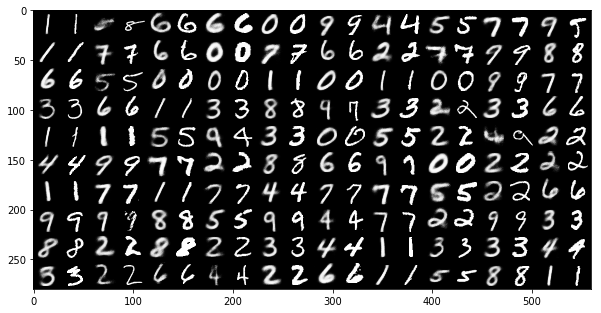

In [9]:
plt.show()

In [11]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generate(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

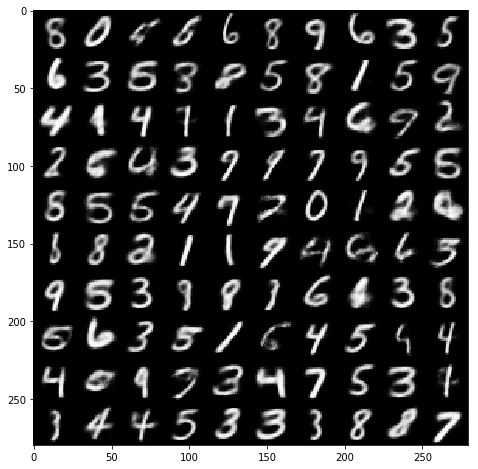

In [12]:
plt.show()


In [16]:
tf.reset_default_graph()
# Train the model with 2d latent space
model_2d = trainer(learning_rate=1e-4,  batch_size=100, epoch=50, n_z=2)

[Epoch 0] Loss: 185.51904296875
[Epoch 1] Loss: 171.5819854736328
[Epoch 2] Loss: 170.64112854003906
[Epoch 3] Loss: 163.3558349609375
[Epoch 4] Loss: 156.97592163085938
[Epoch 5] Loss: 164.2252960205078
[Epoch 6] Loss: 163.12062072753906
[Epoch 7] Loss: 163.89105224609375
[Epoch 8] Loss: 164.1309814453125
[Epoch 9] Loss: 166.19012451171875
[Epoch 10] Loss: 160.07553100585938
[Epoch 11] Loss: 155.3448028564453
[Epoch 12] Loss: 155.50357055664062
[Epoch 13] Loss: 158.46839904785156
[Epoch 14] Loss: 156.34739685058594
[Epoch 15] Loss: 155.55130004882812
[Epoch 16] Loss: 151.46609497070312
[Epoch 17] Loss: 150.75527954101562
[Epoch 18] Loss: 158.7879180908203
[Epoch 19] Loss: 150.9512176513672
[Epoch 20] Loss: 151.96054077148438
[Epoch 21] Loss: 152.6497802734375
[Epoch 22] Loss: 144.0262451171875
[Epoch 23] Loss: 154.25308227539062
[Epoch 24] Loss: 148.58502197265625
[Epoch 25] Loss: 151.4247589111328
[Epoch 26] Loss: 143.68507385253906
[Epoch 27] Loss: 146.3594512939453
[Epoch 28] Loss:

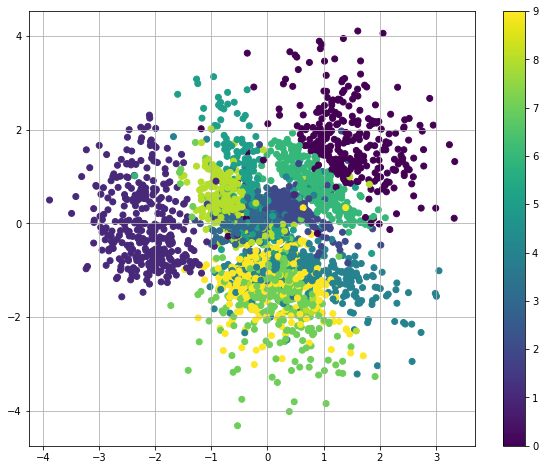

In [17]:
# Test the trained model: transformation
batch = mnist.test.next_batch(3000)
z = model_2d.transformer(batch[0])
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1))
plt.colorbar()
plt.grid()
plt.show()

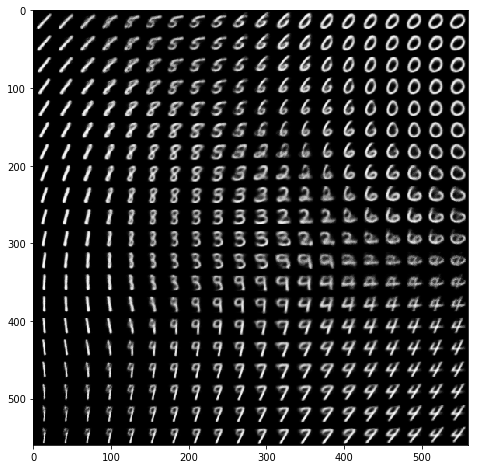

In [20]:
# Test the trained model: transformation
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generate(z)
        I_latent[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_hat[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")
plt.show()